# Deepfake detection with MobileNetV2

# Import Libraries

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import cv2

In [16]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available:", gpus)

TensorFlow version: 2.15.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# Ensure TensorFlow is using the GPU
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [18]:
tf.keras.backend.clear_session() #clean session

# Load Dataset
#### 140k Real and Fake Faces
***70k real faces (from Flickr) and 70k fake faces (GAN-generated)***
- Link: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces



In [19]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [20]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


## Labeled dictionary

Create a dictionary with three keys:

* **folder**: train, validation and test folders
* **image_path**: path of the images
* **label**: image's label (fake or real)

In [21]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [22]:
images_df = pd.DataFrame(images_df)
images_df

,folder,image_path,label
0,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
1,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
2,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
3,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
4,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
...,...,...,...
139995,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139996,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139997,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139998,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real


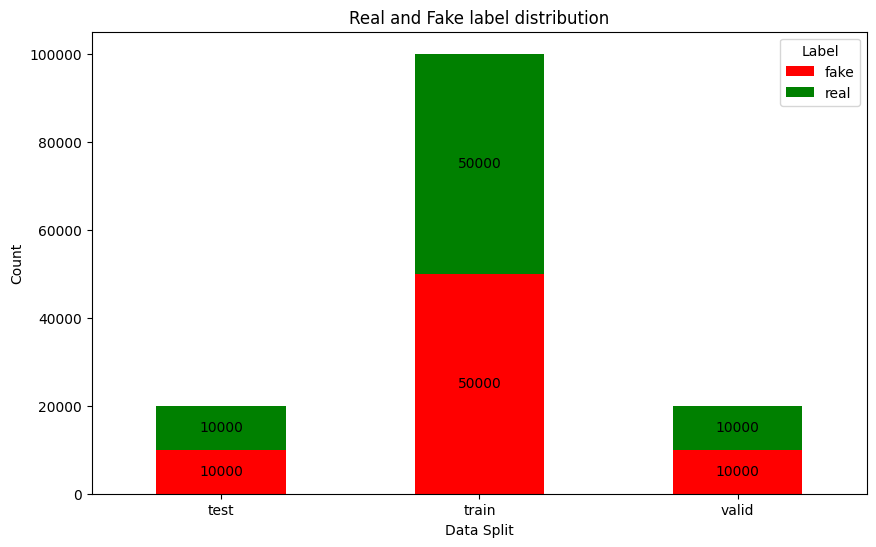

In [23]:
# Group by 'folder' and 'label' to get the count of each label in each split
label_counts = images_df.groupby(['folder', 'label']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = label_counts.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

# Add exact count labels on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, int(height), ha='center', va='center')

plt.title('Real and Fake label distribution')
plt.xlabel('Data Split')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=0)
plt.show()


### Reduce training data

In [24]:
train_fake = images_df[(images_df['folder'] == 'train') & (images_df['label'] == 'fake')]
train_real = images_df[(images_df['folder'] == 'train') & (images_df['label'] == 'real')]

# randomly sample 30000 image each on real fake on training to reduce amount of training data
# because not enough cpu
train_fake = train_fake.sample(n=30000, random_state=42)
train_real = train_real.sample(n=30000, random_state=42)

# combine sampling results
reduced_train_df = pd.concat([train_fake, train_real])

images_df = images_df[images_df['folder'] != 'train']

In [25]:
images_df['folder'].unique()

array(['valid', 'test'], dtype=object)

In [26]:
reduced_train_df[reduced_train_df.label == 'real'].shape

(30000, 3)

In [27]:
images_df = pd.concat([images_df, reduced_train_df])

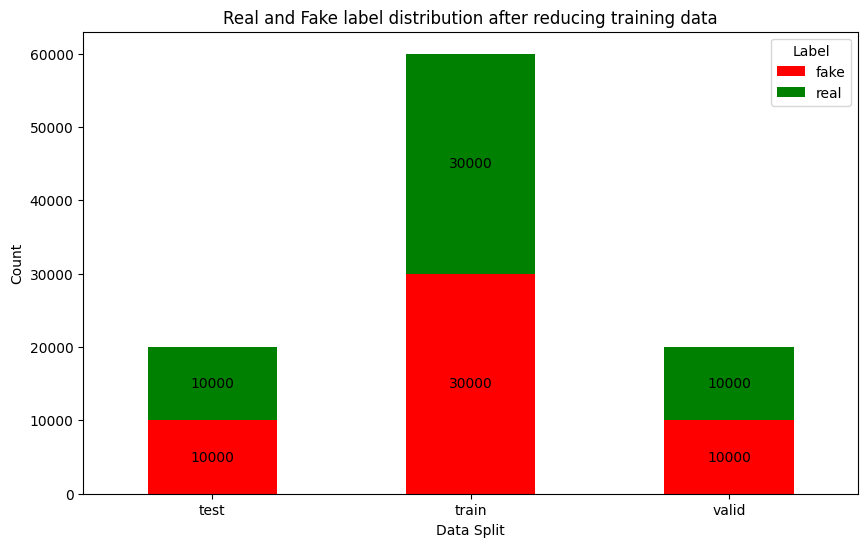

In [28]:
# Group by 'folder' and 'label' to get the count of each label in each split
label_counts = images_df.groupby(['folder', 'label']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = label_counts.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

# Add exact count labels on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, int(height), ha='center', va='center')

plt.title('Real and Fake label distribution after reducing training data')
plt.xlabel('Data Split')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=0)
plt.show()

In [29]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]


def plot_images(images_df):
    plt.figure(figsize=[8, 8])

    # Filter for fake and real images
    fake_images = images_df[images_df['label'] == 'fake'].tail(8)
    real_images = images_df[images_df['label'] == 'real'].tail(8)

    # Combine both fake and real images
    combined_images = pd.concat([fake_images, real_images])

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img_path = combined_images.iloc[i]['image_path']
        label = combined_images.iloc[i]['label']
        plt.imshow(load_img(img_path), cmap='gray')
        plt.axis('off')
        plt.title(label)

In [ ]:
# Call the function to plot images
plot_images(images_df)
plt.show()

## Label Distribution

In [ ]:
images_df.shape

(100000, 3)

Total amount of images in the dataset is **140.000**

In [34]:
# # Group by 'folder' and 'label' to get the count of each label in each split
# label_counts = images_df.groupby(['folder', 'label']).size().unstack(fill_value=0)

# # Plot the stacked bar chart
# ax = label_counts.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

# # Add exact count labels on the bars
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     ax.text(x + width/2, y + height/2, int(height), ha='center', va='center')

# plt.title('Real and Fake label distribution')
# plt.xlabel('Data Split')
# plt.ylabel('Count')
# plt.legend(title='Label')
# plt.xticks(rotation=0)
# plt.show()


As we can see, the dataset is splitted into:
* train (100000 images)
* test (20000 images)
* validation (20000 images)

# MobileNetV2

In [ ]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the model
model_mnet = Sequential([
    mnet,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
#     Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model_mnet.build(input_shape=(None, 96, 96, 3))

# Compile the model
model_mnet.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_mnet.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981,826 (11.37 MB)

 Trainable params: 2,946,690 (11.24 MB)

 Non-trainable params: 35,136 (137.25 KB)

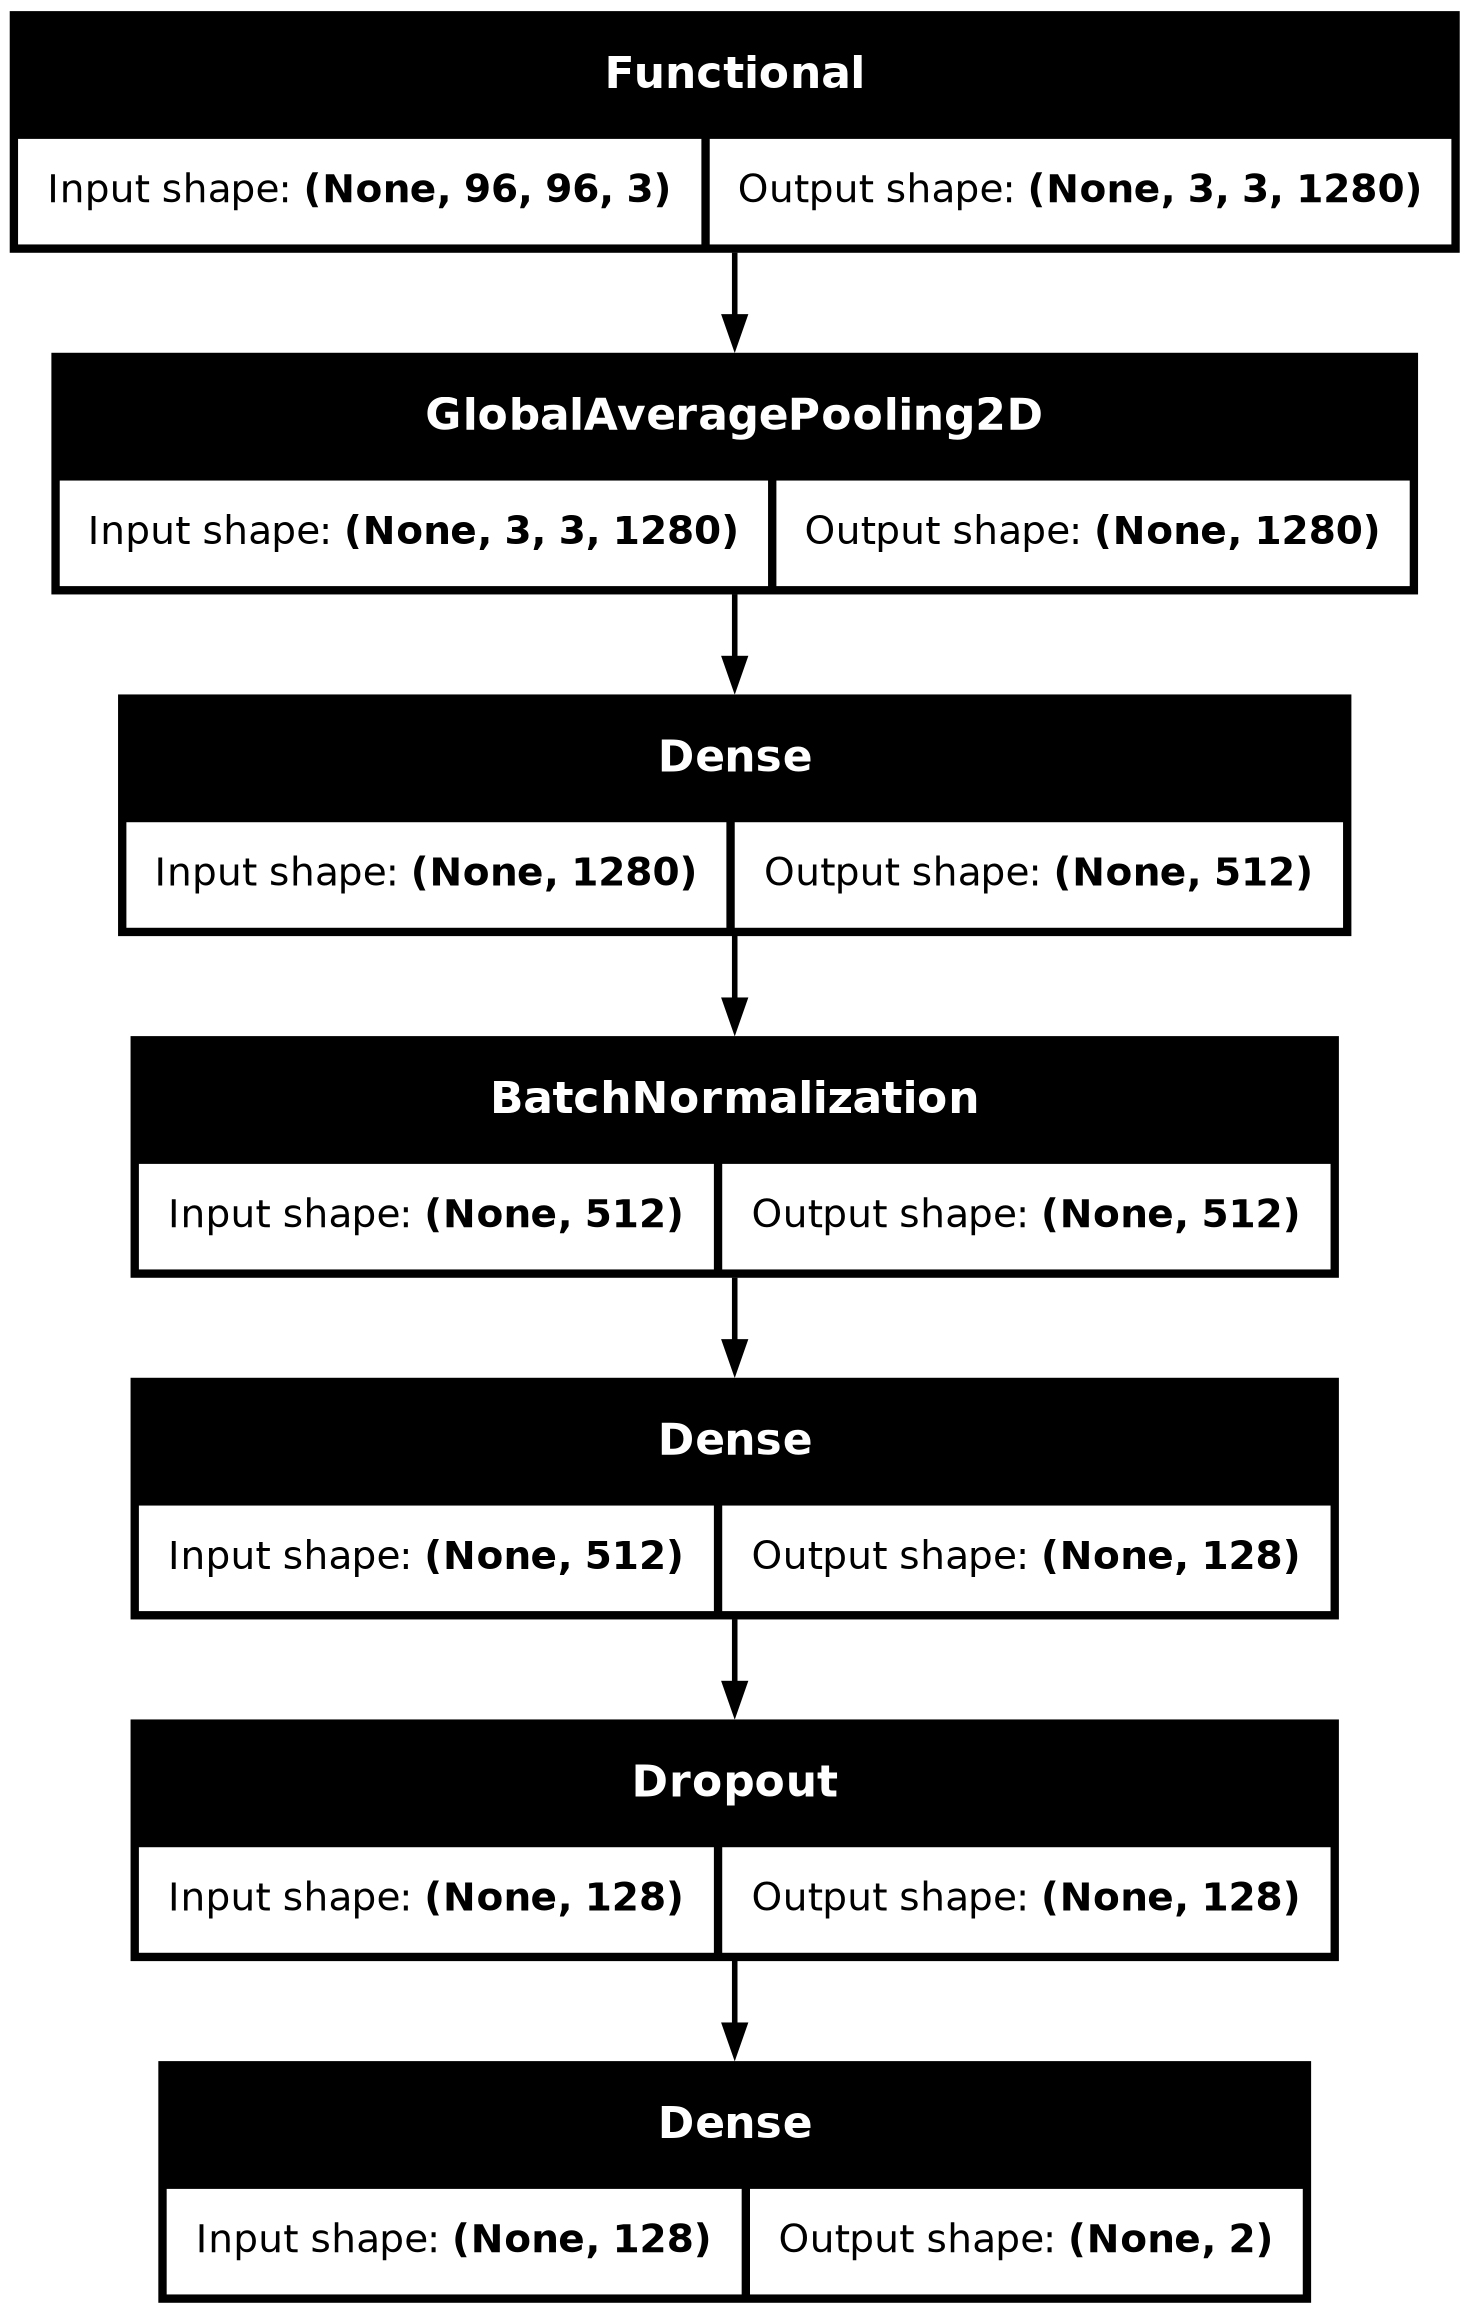

In [ ]:
tf.keras.utils.plot_model(model_mnet, show_shapes=True)

### Callback & Early Stopping

**ModelCheckpoint** callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. In this case, we don't have to worry about training for too long and overfitting the training set.



In [ ]:
checkpoint_filepath = "/kaggle/working/model_mnet.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

The **EarlyStopping** callback stops training when a monitored metric (in this case val_loss) has stopped improving (in this case decreasing).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

**ReduceOnPlateau** callback reduces learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

# Preprocessing

In [ ]:
# Preprocess the images and labels using TensorFlow operations
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image = image / 255.0  # Normalize
    return image, label

def load_and_preprocess_from_path_label(path, label):
    return preprocess_image(path, label)

# Create a TensorFlow dataset from the DataFrame
def create_dataset(df, batch_size=32, shuffle=True):
    paths = df['image_path'].values
    labels = df['label'].apply(lambda x: 0 if x == 'fake' else 1).values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Training

In [ ]:
# Split the DataFrame into train, validation, and test sets
train_df = images_df[images_df['folder'] == 'train']
valid_df = images_df[images_df['folder'] == 'valid']
test_df = images_df[images_df['folder'] == 'test']

batch_size = 16
train_dataset = create_dataset(train_df, batch_size)
valid_dataset = create_dataset(valid_df, batch_size, shuffle=False)

In [ ]:
history_ft = model_mnet.fit(train_dataset,
                       epochs = 6,
                       validation_data = valid_dataset,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/6
   3/3750 ━━━━━━━━━━━━━━━━━━━━ 1:37 26ms/step - accuracy: 0.5486 - loss: 1.0795     

I0000 00:00:1719428831.958312     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719428832.023089     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3749/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7657 - loss: 0.5553

W0000 00:00:1719428908.702061     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 294s 31ms/step - accuracy: 0.7658 - loss: 0.5552 - val_accuracy: 0.7865 - val_loss: 1.7362 - learning_rate: 0.0010
Epoch 2/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.9185 - loss: 0.2086 - val_accuracy: 0.5000 - val_loss: 8.7270 - learning_rate: 0.0010
Epoch 3/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.9197 - loss: 0.2020 - val_accuracy: 0.9234 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 4/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.9551 - loss: 0.1226 - val_accuracy: 0.8400 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 5/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - accuracy: 0.9657 - loss: 0.0920 - val_accuracy: 0.7950 - val_loss: 0.7923 - learning_rate: 0.0010
Epoch 6/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 111s 23ms/step - accuracy: 0.9713 - loss: 0.0790 - val_accuracy: 0.9063 - val_loss: 0.3863 - learning_rate: 0.0010


In [ ]:
model_mnet.save(mnet.h5)

AttributeError: 'Functional' object has no attribute 'h5'

## Training Result

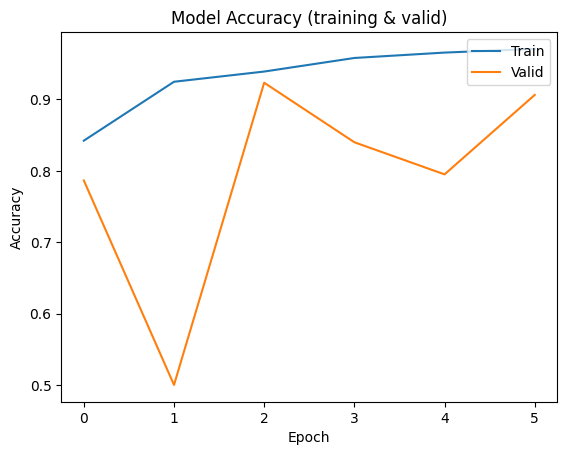

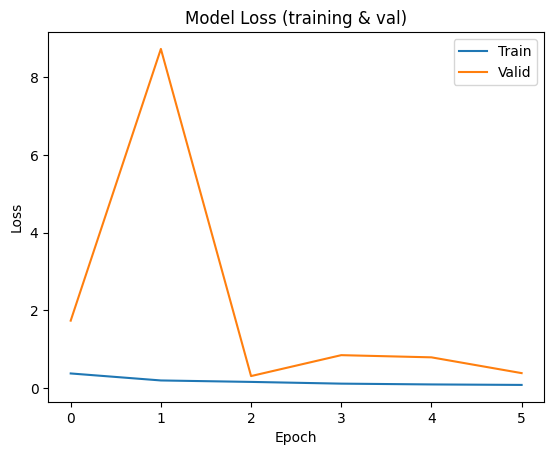

In [ ]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


The model is clearly overfitted. So wee have to restore the model weights from the ModelCheckpoint callback.

Let's try to evaluate the full overfitted model. We can see that it has a poor performance.

In [ ]:
test_dataset = create_dataset(test_df, batch_size, shuffle=False)

# Evaluate the model on the test set
test_loss, test_acc = model_mnet.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9445 - loss: 0.1874
Test Loss: 0.3003585934638977
Test Accuracy: 0.9277999997138977


Here a Model Checkpoint callback is necessary. Indeed loading the best weights results in a much better performance on the test set.

In [ ]:
# Restore the weights
model_mnet.load_weights('/kaggle/working/model_mnet.weights.h5')

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_mnet.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Qualitative Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Text(0.5, 1.0, 'This image is 0.09% Fake and 99.91% Real.')

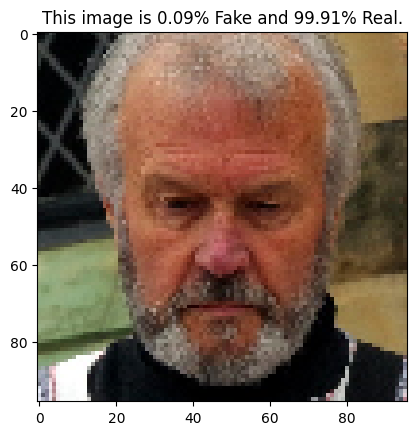

In [ ]:
#fake example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00142.jpg', target_size=(96, 96, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model_mnet.predict(test_image_arr)

plt.title(f"This image is {100 * result[0][0]:.2f}% Fake and {100 * (1 - result[0][0]):.2f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Text(0.5, 1.0, 'This image is 99.47% Fake and 0.53% Real.')

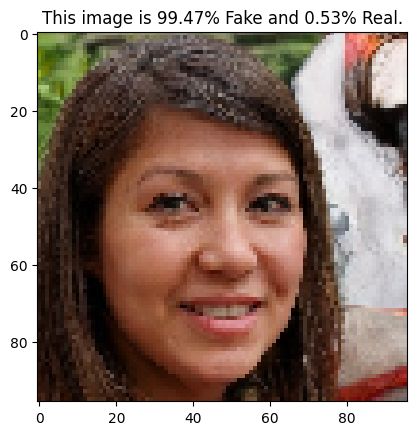

In [ ]:
# real example

real = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/06EXMB0ZGF.jpg'
#real example
test_image = tf.keras.preprocessing.image.load_img(real, target_size=(96, 96, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model_mnet.predict(test_image_arr)


plt.title(f"This image is {100 * result[0][0]:.2f}% Fake and {100 * (1 - result[0][0]):.2f}% Real.")

In [ ]:
predicted_labels = model_mnet.predict(test_dataset)

  23/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step 

W0000 00:00:1719429759.243373     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step


In [ ]:
predicted_labels

array([[1.0000000e+00, 1.5799706e-09],
       [1.0000000e+00, 1.2934165e-13],
       [1.0000000e+00, 1.2988674e-17],
       ...,
       [9.0651198e-10, 1.0000000e+00],
       [7.9917882e-05, 9.9992013e-01],
       [3.3384045e-03, 9.9666160e-01]], dtype=float32)

In [ ]:
true_labels = test_df['label']
true_labels.value_counts()

label
fake    10000
real    10000
Name: count, dtype: int64

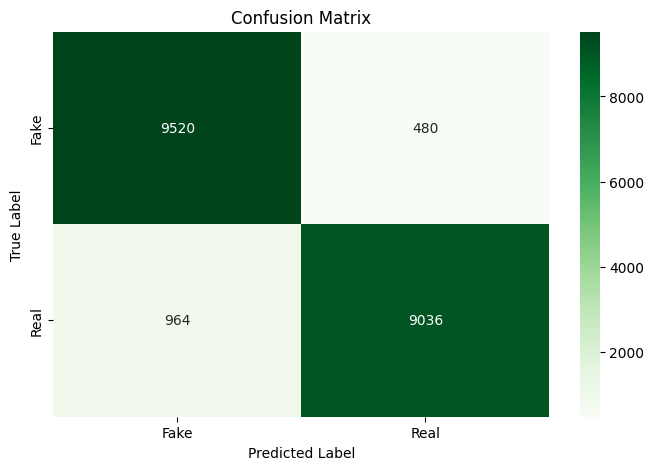

In [ ]:
# Convert true labels to binary format
true_labels_binary = test_df['label'].apply(lambda x: 0 if x == 'fake' else 1).values

# Convert predicted labels to binary format by taking the class with the highest probability
predicted_labels_binary = np.where(predicted_labels[:, 0] > predicted_labels[:, 1], 0, 1)

# Create the confusion matrix
conf_matrix = metrics.confusion_matrix(true_labels_binary, predicted_labels_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


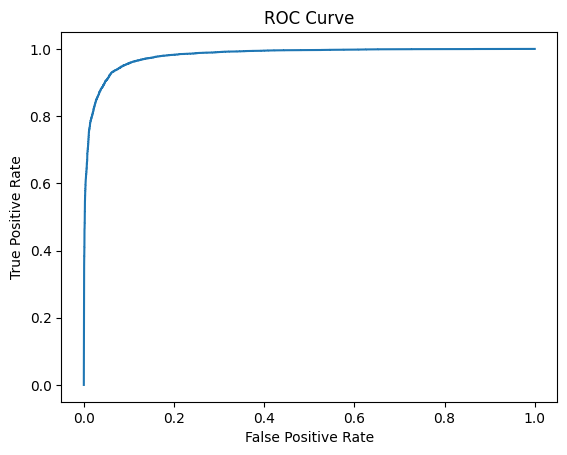

Optimal threshold: 0.3661530315876007


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels_binary, predicted_labels[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Choose a new threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

predicted_labels_binary = (predicted_labels[:, 1] >= optimal_threshold).astype(int)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels_binary, predicted_labels_binary, target_names=['Fake', 'Real']))


              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93     10000
        Real       0.94      0.93      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

